### Imports

In [47]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

import tempfile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Bidirectional, LSTM, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def read_df_and_display_num_rows_columns(filepath):
    df = pd.read_csv(filepath)
    print(f"Reading file: {filepath}")
    print(f"number of rows: {df.shape[0]}")
    print(f"number of columns: {df.shape[1]}")
    return df

In [3]:
df_train = read_df_and_display_num_rows_columns("/content/drive/MyDrive/test-ml/snli_data_train.csv")
df_val = read_df_and_display_num_rows_columns("/content/drive/MyDrive/test-ml/snli_data_val.csv")
df_test = read_df_and_display_num_rows_columns("/content/drive/MyDrive/test-ml/snli_data_test.csv")

Reading file: /content/drive/MyDrive/test-ml/snli_data_train.csv
number of rows: 549367
number of columns: 3
Reading file: /content/drive/MyDrive/test-ml/snli_data_val.csv
number of rows: 9842
number of columns: 3
Reading file: /content/drive/MyDrive/test-ml/snli_data_test.csv
number of rows: 9824
number of columns: 3


In [4]:
df_train.head()

,label,premise,hypothesis
0,neutral,person horse jumps broken airplane,person training horse competition
1,contradiction,person horse jumps broken airplane,person diner ordering omelette
2,entailment,person horse jumps broken airplane,person outdoors horse
3,neutral,children smiling waving camera,smiling parents
4,entailment,children smiling waving camera,children present


In [6]:
output_dimension = 300
lstm_units = 64
maximum_len = 50
trainable = False #we do not want weights of the embedding layer to be updated during the training process
hidden_size = 300

In [38]:
# Parameters
VOCAB_SIZE = 40000
L2 = 4e-6
DROPOUT = 0.2
LEARNING_RATE = 0.01
RHO = 0.9
EPSILON = 1e-08
DECAY = 0.0

CATEGORIES = 3
BATCH_SIZE = 512
TRAINING_EPOCHS = 25

PATIENCE = 5

In [8]:
def load_glove_embeddings(embedding_dim):
    embedding_dict = {}
    with open(f'/content/drive/MyDrive/test-ml/glove.6B.{embedding_dim}d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype=float)
            embedding_dict[word] = vector
    return embedding_dict

In [9]:
def remove_null_from_df(df, name):
  print(f"Number of null rows in {name}")
  print(df.isnull().sum())
  df = df.dropna().reset_index(drop=True)
  return df

In [10]:
data_train = remove_null_from_df(df_train, "SNLI train dataset")
data_val = remove_null_from_df(df_val,  "SNLI validation dataset")

Number of null rows in SNLI train dataset
label          0
premise        0
hypothesis    17
dtype: int64
Number of null rows in SNLI validation dataset
label         0
premise       0
hypothesis    0
dtype: int64


In [12]:
corpus = data_train['premise'] + ' ' + data_train['hypothesis']

In [45]:
def embedding_matrix(corpus, glove_embedding, embedding_dim):
    # Initialize and fit Keras tokenizer to convert words to integers
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(corpus)

    # Get an word-integer dictionary and use that to create an weight matrix
    # i-th column of weight matrix will have the vector of word with integer value i in dictionary
    word_index = tokenizer.word_index
    embed_matrix = np.zeros((len(word_index) + 1, embedding_dim))

    for word, ind in word_index.items():
        # Get the embedding vector from GloVe dictionary, if available
        # Words not in the Glove would have the embedding matrix vector as full zeroes
        embedding_vector = glove_embedding.get(word)

        if embedding_vector is not None:
            embed_matrix[ind] = embedding_vector

    return embed_matrix, tokenizer

In [17]:
embedding_dim = 300
embedding_dict = load_glove_embeddings(embedding_dim)
embed_matrix, tokenizer = embedding_matrix(corpus, embedding_dict, embedding_dim)

In [46]:
def preprocess_data(df):
    # Define MAX_SEQ_LEN and NUM_CLASSES
    processed_data = []

    label_map = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
    # Replace string labels with numerical labels
    df['label'] = df['label'].replace(label_map)
    
    for index, row in df.iterrows():
        # Get label, premise, and hypothesis from the row
        label = row['label']
        premise = row['premise']
        hypothesis = row['hypothesis']
        
        # Apply tokenizer and pad_sequence to premise and hypothesis
        premise_seq = pad_sequences(tokenizer.texts_to_sequences([premise]), maxlen=maximum_len)[0]
        hypothesis_seq = pad_sequences(tokenizer.texts_to_sequences([hypothesis]), maxlen=maximum_len)[0]
        label_new = to_categorical(label, num_classes=3)
        
        # Append the processed data as a tuple to the list
        processed_data.append((premise_seq, hypothesis_seq, label_new))
    
    return pd.DataFrame(processed_data, columns=['premise', 'hypothesis', 'label'])

In [19]:
snli_data_train_copy = data_train.copy()
processed_train_data = preprocess_data(snli_data_train_copy)
processed_train_data.head()

,premise,hypothesis,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0]"
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 1.0]"
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0]"
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 1.0]"


In [23]:
snli_data_val_copy = data_val.copy()
snli_data_val_copy

,label,premise,hypothesis
0,neutral,two women embracing holding go packages,sisters hugging goodbye holding go packages ea...
1,entailment,two women embracing holding go packages,two woman holding packages
2,contradiction,two women embracing holding go packages,men fighting outside deli
3,entailment,two young children blue jerseys one number nin...,two kids numbered jerseys wash hands
4,neutral,two young children blue jerseys one number nin...,two kids ballgame wash hands
...,...,...,...
9837,entailment,small girl wearing pink jacket riding carousel,carousel moving
9838,contradiction,small girl wearing pink jacket riding carousel,girl moving speed light
9839,entailment,young girl blue pink ribbons braids without to...,people water fountain
9840,contradiction,young girl blue pink ribbons braids without to...,young girl knits sweater


In [24]:
snli_data_val_copy = data_val.copy()
processed_val_data = preprocess_data(snli_data_val_copy)
processed_val_data.head()

,premise,hypothesis,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0]"
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 1.0]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0]"
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 1.0]"
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0]"


In [43]:
# Trains the BiLSTM model using the data passed as argument
def BL_model_train(train_data, embed_matrix):
    embedding = Embedding(input_dim=embed_matrix.shape[0], output_dim=output_dimension, weights=[embed_matrix], input_length=maximum_len, trainable=trainable)
    BiLSTM = Bidirectional(LSTM(lstm_units))
    # For better performance, apply TimeDistributed layer, with 200 neurons and the ReLU activation function to each time step of the input sequence independently.
    translation = TimeDistributed(Dense(output_dimension, activation='relu'))
    # Define input layers and its shapes and types for premise and hypothesis
    premise = Input(shape=(maximum_len,), dtype='int32')
    hypothesis = Input(shape=(maximum_len,), dtype='int32')
    # Embed premise and hypothesis to transform high-dimensional input data into a lower-dimensional vector space that is easier for the model to work with.
    premise_embedded, hypothesis_embedded = [embedding(input_) for input_ in [premise, hypothesis]]
    # Apply translation layer 
    premise_timeDistributed, hypothesis_timeDistributed = [translation(embedded_) for embedded_ in [premise_embedded, hypothesis_embedded]]
    # Apply bidirectional LSTM layer
    premise_BiLSTM, hypothesis_BiLSTM = [BiLSTM(time_distributed_) for time_distributed_ in [premise_timeDistributed, hypothesis_timeDistributed]]
    # Apply Batch normalization
    premise_normalized, hypothesis_normalized = [BatchNormalization()(output) for output in [premise_BiLSTM, hypothesis_BiLSTM]]
    # Concatenate normalized premise and hypothesis and apply a dropout layer
    train_input = concatenate([premise_normalized, hypothesis_normalized])
    train_input = Dropout(0.2)(train_input)
    # Apply a series of Dense, Dropout, and BatchNormalization layers so that model understand a deeper connection in our data
    for i in range(3):
        train_input = Dense(2 * hidden_size, activation='relu', kernel_regularizer=l2(4e-6))(train_input) #L2 regularizer is more commonly used
        train_input = Dropout(0.2)(train_input)
        train_input = BatchNormalization()(train_input)
  
    # Define the output Dense layer
    prediction = Dense(3, activation='softmax')(train_input) # softmax is used since it transforms vector into a probability distribution over the classes.
    model = Model(inputs=[premise, hypothesis], outputs=prediction)
    # Define an optimizer
    optimizer = Adam(learning_rate=0.01)
    # Compile the model and print out the model summary
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [36]:
import tensorflow as tf
tensor_premise = tf.convert_to_tensor(tf.constant(processed_train_data['premise'].tolist()))
tensor_hypothesis = tf.convert_to_tensor(tf.constant(processed_train_data['hypothesis'].tolist()))
tensor_label = tf.convert_to_tensor(tf.constant(processed_train_data['label'].tolist()))

In [37]:
val_premise = tf.convert_to_tensor(tf.constant(processed_val_data['premise'].tolist()))
val_hypothesis = tf.convert_to_tensor(tf.constant(processed_val_data['hypothesis'].tolist()))
val_label = tf.convert_to_tensor(tf.constant(processed_val_data['label'].tolist()))

In [40]:
print("Training model")

model = BL_model_train(processed_train_data, embed_matrix)
    # ReduceLROnPlateau callback to reduce learning rate when the validation accuracy plateaus
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=PATIENCE, verbose=1, factor=0.5, min_lr=0.00001)
# early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE)

_, tmpfn = tempfile.mkstemp()
model_checkpoint = ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)
# callbacks = [early_stopping, model_checkpoint, learning_rate_reduction]
callbacks = [model_checkpoint, learning_rate_reduction]
# Train model
history = model.fit(x=[tensor_premise, tensor_hypothesis], y=tensor_label, batch_size=BATCH_SIZE, epochs=TRAINING_EPOCHS, validation_data=([val_premise, val_hypothesis], val_label), callbacks=callbacks)
# Restore the best found model during validation
model.load_weights(tmpfn)
# Save the model as h5 file
model.save("/content/drive/MyDrive/test-ml/BiLSTM.h5")

Training model
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 300)      9885900     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 50, 300)     90300       ['embedding_

In [41]:
def plot_model_training(hist):
  """Function to plot accuracy and loss for iterations for the training and validation data set of the model
     Args:
       model: trained model"""
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  # Plot accuracy
  ax1.plot(hist.history['accuracy'])
  ax1.plot(hist.history['val_accuracy'])
  ax1.set_title('Model Accuracy')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'], loc='upper right')

  # Plot loss
  ax2.plot(hist.history['loss'])
  ax2.plot(hist.history['val_loss'])
  ax2.set_title('Model Loss')
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'], loc='upper right')

  plt.show()

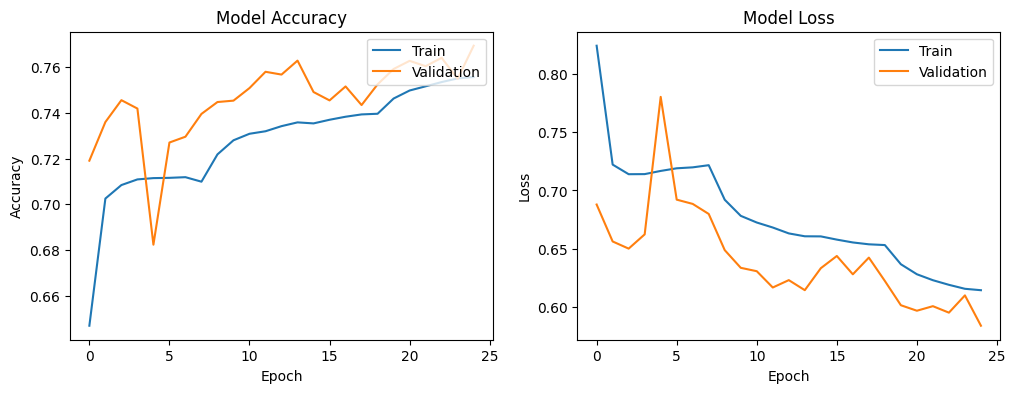

In [42]:
plot_model_training(history)

In [48]:
import pickle
def save_to_pickle(df, filename):
  df.to_pickle(filename)

In [49]:
save_to_pickle(processed_train_data, '/content/drive/MyDrive/test-ml/nli_train.pickle')
save_to_pickle(processed_val_data, '/content/drive/MyDrive/test-ml/nli_val.pickle')